Import modules

In [2]:
# import part
import zipfile
import os
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import normaltest, shapiro
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, RFE, mutual_info_classif, RFECV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline


Import data and split data

In [3]:
with zipfile.ZipFile('tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)

How many features are normally distributed with and without transformation?

In [4]:
normal_features = []
non_normal_features = []

for feature in X_train.columns:  
    stat, p = shapiro(X_train[feature])
    if p > 0.05:
        normal_features.append(feature)
    else:
        non_normal_features.append(feature)

print(f"Normal Features: {len(normal_features)}")
print(f"Non-Normal Features: {len(non_normal_features)}")

t_normal_features = []
t_non_normal_features = []

data_transformed = np.log1p(X_train)
for feature in data_transformed.columns: 
    stat, p = shapiro(data_transformed[feature])  
    if p > 0.05:
        t_normal_features.append(feature)
    else:
        t_non_normal_features.append(feature)

print(f"Transformed Normal Features: {len(t_normal_features)}")
print(f"Transformed Non-Normal Features: {len(t_non_normal_features)}")

Normal Features: 0
Non-Normal Features: 9000
Transformed Normal Features: 400
Transformed Non-Normal Features: 8600


Look at correlation heatmap to see if PCA is needed

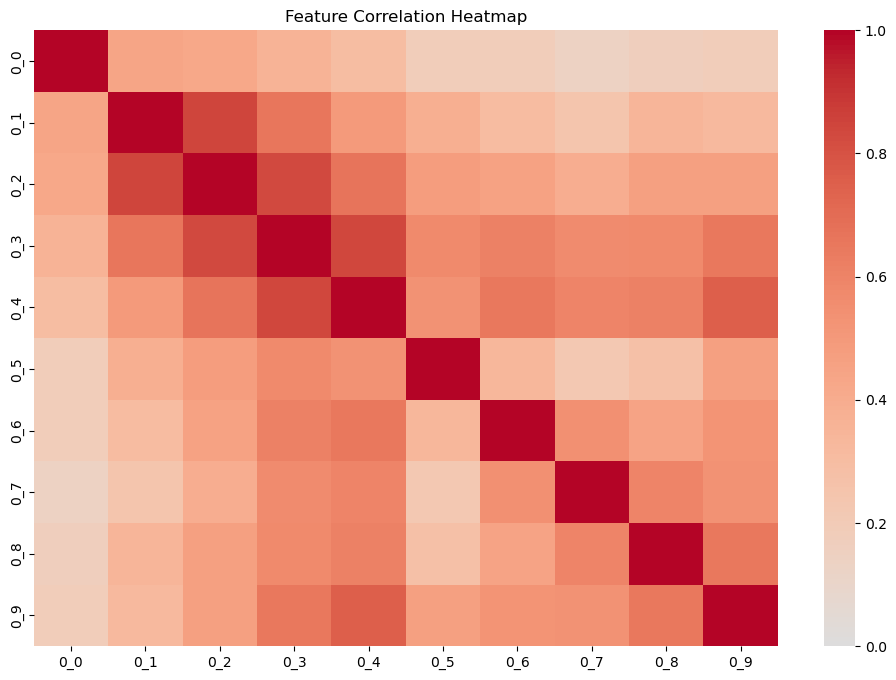

In [ ]:
# Compute correlation matrix
correlation_matrix = X_train.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix.iloc[:10, :10], cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

When selecting the best 400 features are these normally distributed? Method: mutual_info_classif and RFECV

In [7]:
# Select top 400 features with the highest F-statistic
selector = SelectKBest(score_func=mutual_info_classif, k=400)
X_train_selected = selector.fit_transform(X_train, y_train)

# Use LDA as the estimator (since it's similar to QDA but more stable for feature selection)
lda = LinearDiscriminantAnalysis()  # LDA as a baseline for QDA

# Cross-validation
cv = StratifiedKFold(n_splits=5)

rfecv = RFECV(estimator=lda, step=1, cv=cv, scoring='accuracy', n_jobs=-1)
X_train_final = rfecv.fit_transform(X_train_selected, y_train)
X_train_final = np.log1p(X_train_final)

# Check normality
normal_features = []
non_normal_features = []

for feature in range(X_train_final.shape[1]):
    stat, p = shapiro(X_train_final[:, feature])
    if p > 0.05:
        normal_features.append(feature)
    else:
        non_normal_features.append(feature)

print(f"Normal Features: {len(normal_features)}")
print(f"Non-Normal Features: {len(non_normal_features)}")

Normal Features: 0
Non-Normal Features: 1


When selecting the best 400 features are these normally distributed? Method: mutual_info_classif and RFE

In [8]:
# Select top 400 features with the highest F-statistic
selector = SelectKBest(score_func=mutual_info_classif, k=400)
X_train_selected = selector.fit_transform(X_train, y_train)

# Use LDA as the estimator (since it's similar to QDA but more stable for feature selection)
lda = LinearDiscriminantAnalysis()  # LDA as a baseline for QDA

rfe = RFE(estimator=lda, n_features_to_select=100)
X_train_final = rfe.fit_transform(X_train_selected, y_train)
X_train_final = np.log1p(X_train_final)

# Check normality
normal_features = []
non_normal_features = []

for feature in range(X_train_final.shape[1]):
    stat, p = shapiro(X_train_final[:, feature])
    if p > 0.05:
        normal_features.append(feature)
    else:
        non_normal_features.append(feature)

print(f"Normal Features: {len(normal_features)}")
print(f"Non-Normal Features: {len(non_normal_features)}")

Normal Features: 0
Non-Normal Features: 100
